In [121]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from model.lstm import LSTM_Model
from model.optimizer import config_optimizer
from model.early_stopping import EarlyStopping
from dataset.normalize import Normalizer
from dataset.preparetion import prepare_data
from dataset.travel_time_dataset import TravelTimeDataset

In [165]:
cfg = {
    'data': {
        'path': 'E:/data/time_series_clean/start_stop/1.csv',
        'feature': 'delta_t',
        'window_size': 21,
        'train_split_size': 0.5915,
    },
    'plots': {
        'show_plots': True,
        'color_actual': '#001f3f',
        'color_train': '#3D9970',
        'color_val': '#0074D9',
        'color_pred_train': '#3D9970',
        'color_pred_val': '#0074D9',
        'color_pred_test': '#FF4136',
    },
    'model': {
        'input_size': 1,
        'num_lstm_layers': 2,
        'lstm_size': 32,
        'dropout': 0.5,
    },
    'optimizer': {
        'name': 'adam',
        'lr': 0.001,
        'beta': (0.9, 0.999),
        'eps': 1e-8,
        'weight_decay': 1e-4,
    },
    'scheduler': {
        'step_size': 50,
    },
    'train': {
        'device': 'cuda',
        'batch_size': 8,
        'num_epoch': 100,
        'checkpoint_path': 'E:/checkpoints',
    }
}

# Data preparation: load timeseries data of truck travel time each road

In [166]:
def download_data(cfg, plot=False):
    df = pd.read_csv(cfg['data']['path'], index_col=0, parse_dates=True)
    data_date = [date for date in df.index]
    data_date = np.array(data_date)
    data_date = data_date.reshape(-1, 1)

    data_travel_time = [float(df.loc[df.index == date][cfg['data']['feature']]) for date in df.index]
    data_travel_time = np.array(data_travel_time)
    data_travel_time = data_travel_time.reshape(-1, 1)
    
    num_data_points = len(data_date)
    print(f"Number data points: {num_data_points} from {data_date[0][0]} to {data_date[num_data_points - 1][0]}")
    
    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]
        
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_travel_time, color=cfg['plots']['color_actual']) 
        plt.title(f"Travel time of truck in road {road} and path {path}, from {data_date[0][0]} to {data_date[num_data_points - 1][0]}")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_travel_time, num_data_points

Number data points: 7413 from 2019-01-01 00:00:00 to 2019-12-31 20:00:00


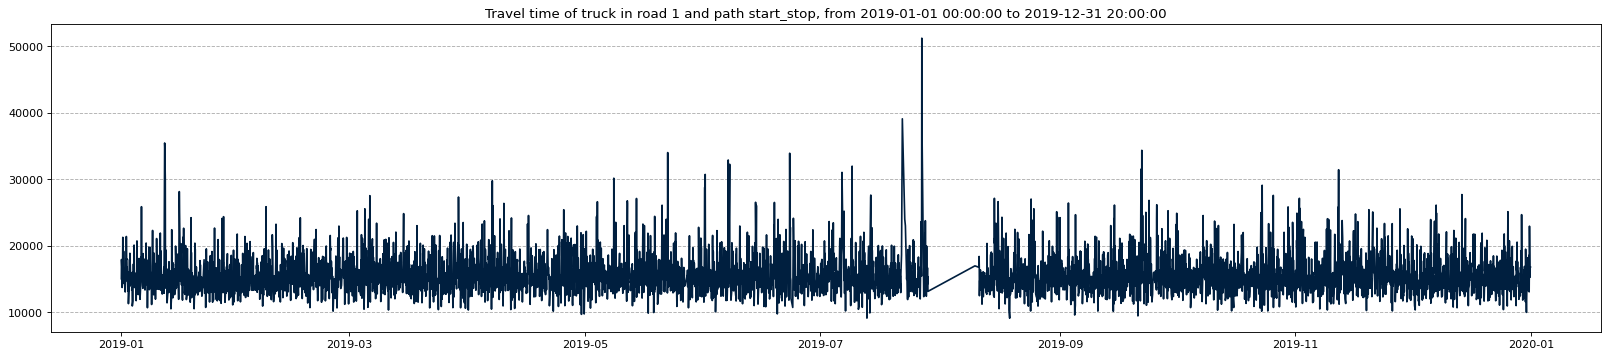

In [167]:
data_date, data_travel_time, num_data_points = download_data(cfg, True)

# Data preparation: normalize raw travel time data

In [168]:
scaler = StandardScaler()
normalize_data_travel_time = scaler.fit_transform(data_travel_time)

# Data preparation: generating training and validation data

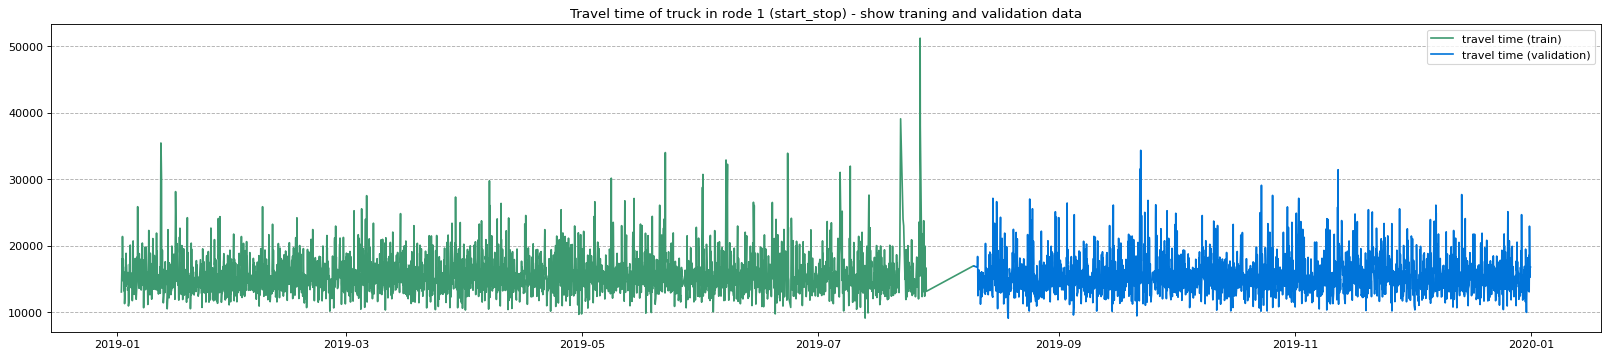

In [169]:
split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalize_data_travel_time, data_date, num_data_points, scaler, cfg, True)

In [170]:
dataset_train = TravelTimeDataset(data_x_train, data_y_train)
dataset_val = TravelTimeDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (4372, 21, 1) (4372,)
Validation data shape (3020, 21, 1) (3020,)


# Define LSTM model

In [171]:
model = LSTM_Model(input_size=cfg['model']['input_size'], hidden_size=cfg['model']['lstm_size'], num_layers=cfg['model']['num_lstm_layers'], output_size=1, dropout=cfg['model']['dropout'])
if torch.cuda.is_available():
    cfg['train']['device'] = 'cuda'
else:
    cfg['train']['device'] = 'cpu'
print(f"Training model use the {cfg['train']['device']}")
model = model.to(cfg['train']['device'])

Training model use the cpu


# Model training

In [172]:
# init tool for train model
# craete dataloader
train_dataloader = DataLoader(dataset_train, batch_size=cfg['train']['batch_size'], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=cfg['train']['batch_size'], shuffle=True)

# define optimizer, sheduler and loss function
criterion = nn.MSELoss()
optimizer = config_optimizer(cfg, model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg['scheduler']['step_size'], gamma=0.1)
early_stopping = EarlyStopping(patience=20, verbose=True, path=cfg['train']['checkpoint_path'])

Using [adam]: learning rate = 0.001, weight_decay = 1e-06


In [173]:
train_losses = []
valid_losses = []
avg_train_losses = []
avg_valid_losses = []

In [174]:
for epoch in range(cfg['train']['num_epoch']):
    print(f"Epoch: {epoch + 1}")

    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (x, y) in enumerate(train_dataloader):
        batch_size = x.shape[0]

        x = x.to(cfg['train']['device'])
        y = y.to(cfg['train']['device'])

        optimizer.zero_grad()
        
        # prediction
        pred = model(x)
        loss = criterion(pred, y)

        loss.backward()
        optimizer.step()
        
        # add train loss
        train_losses.append(loss.detach().item() / batch_size)

        # show status
        # if batch_idx % 20 == 0:
        #     print(f"batch idx: {batch_idx} => train_loss: {loss.item()}")

    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch, (x, y) in enumerate(val_dataloader):
        batch_size = x.shape[0]

        x = x.to(cfg['train']['device'])
        y = y.to(cfg['train']['device'])

        pred = model(x)
        loss = criterion(pred, y)

        # add valid loss
        valid_losses.append(loss.detach().item() / batch_size)

    # update scheduler
    lr = scheduler.get_last_lr()[0]
    scheduler.step()

    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    print(f"[Epoch: {epoch + 1} / {cfg['train']['num_epoch']} || train_loss: {train_loss:.5f} || valid_loss: {valid_loss:.5f} || lr: {lr:.5f}]")

    train_losses = []
    valid_losses = []

    early_stopping(valid_loss, epoch, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break
    

Epoch: 1
[Epoch: 1 / 100 || train_loss: 0.11261 || valid_loss: 0.09897 || lr: 0.00100]
Validation loss decreased (inf --> 0.098975). Saving model ...
Epoch: 2
[Epoch: 2 / 100 || train_loss: 0.10253 || valid_loss: 0.10345 || lr: 0.00100]
EarlyStopping counter: 1 out of 20
Epoch: 3
[Epoch: 3 / 100 || train_loss: 0.10033 || valid_loss: 0.09900 || lr: 0.00100]
EarlyStopping counter: 2 out of 20
Epoch: 4
[Epoch: 4 / 100 || train_loss: 0.10097 || valid_loss: 0.09863 || lr: 0.00100]
Validation loss decreased (0.098975 --> 0.098629). Saving model ...
Epoch: 5
[Epoch: 5 / 100 || train_loss: 0.10011 || valid_loss: 0.09896 || lr: 0.00100]
EarlyStopping counter: 1 out of 20
Epoch: 6
[Epoch: 6 / 100 || train_loss: 0.09643 || valid_loss: 0.10102 || lr: 0.00100]
EarlyStopping counter: 2 out of 20
Epoch: 7
[Epoch: 7 / 100 || train_loss: 0.09688 || valid_loss: 0.09748 || lr: 0.00100]
Validation loss decreased (0.098629 --> 0.097483). Saving model ...
Epoch: 8
[Epoch: 8 / 100 || train_loss: 0.09467 || v

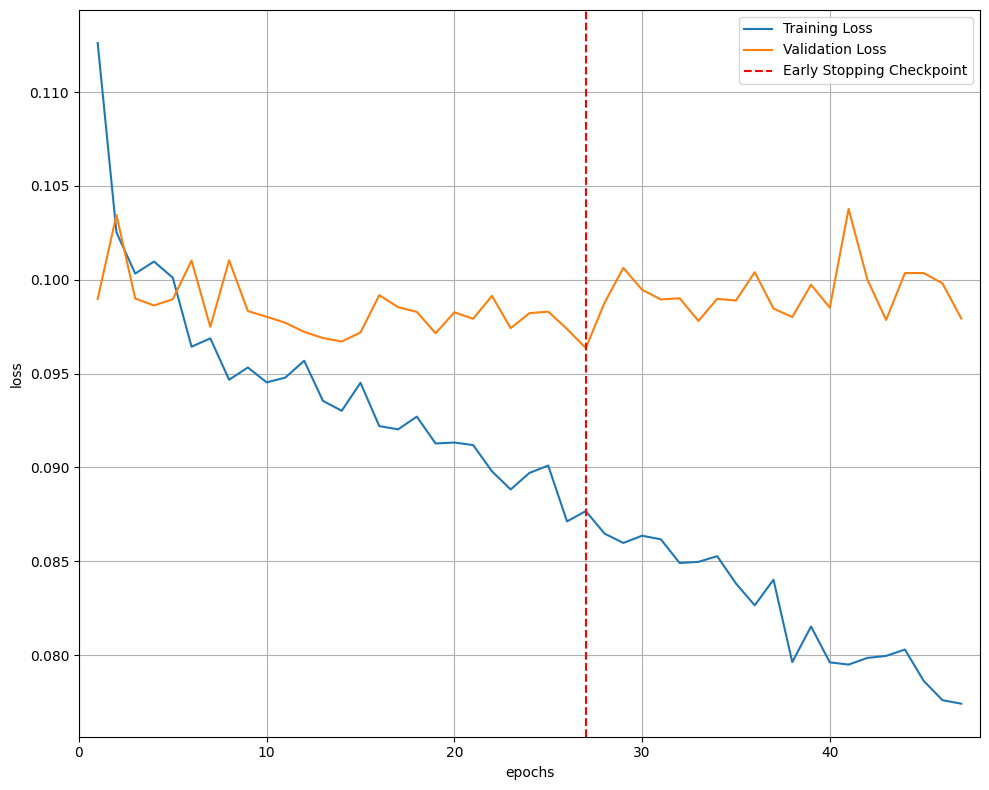

In [176]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, label='Training Loss')
plt.plot(range(1, len(avg_valid_losses) + 1), avg_valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
# plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Model evaluation

In [160]:
train_dataloader = DataLoader(dataset_train, batch_size=cfg['train']['batch_size'], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=cfg['train']['batch_size'], shuffle=False)

In [177]:
checkpoint = torch.load(os.path.join(cfg['train']['checkpoint_path'],'lstm_27_0.096.pth'))
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

MSE : 8440128.519654198
RMSE : 2905.1899283272683
MAE : 2149.717760142451


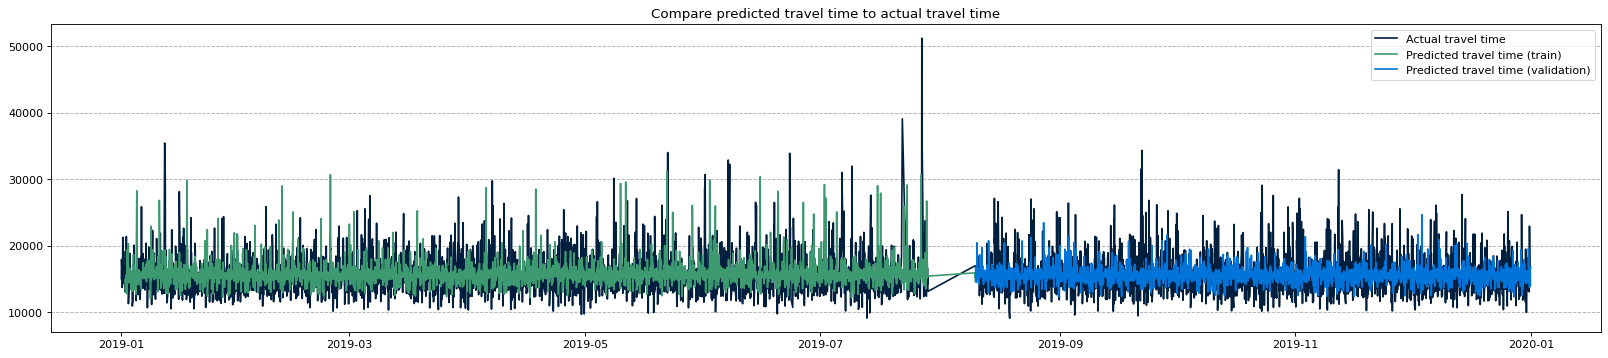

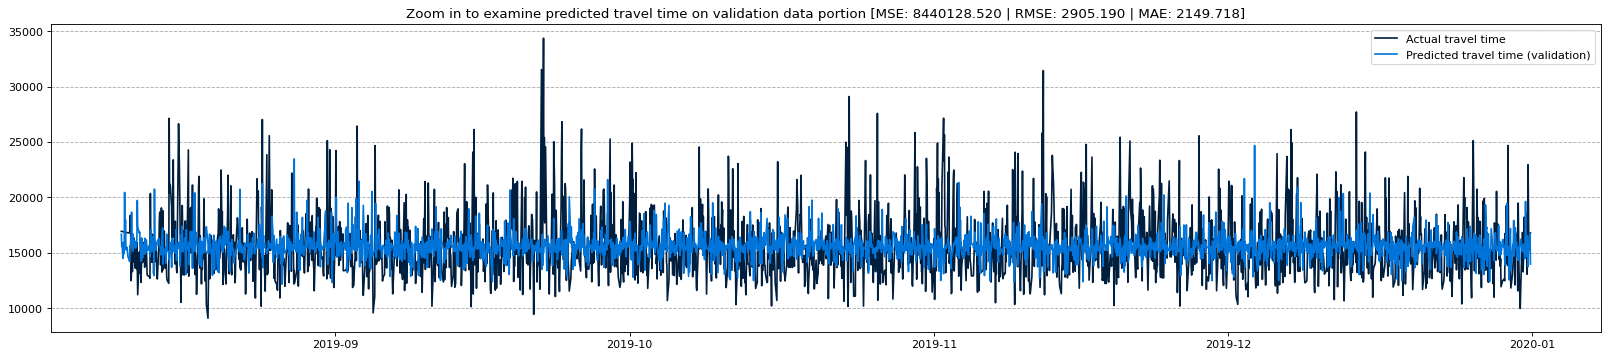

In [178]:
predicted_train = np.array([])
predicted_val = np.array([])

model.eval()
for batch_idx, (x, y) in enumerate(train_dataloader):
    x = x.to(cfg['train']['device'])
    pred = model(x)
    pred = pred.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, pred))

for batch_idx, (x, y) in enumerate(val_dataloader):
    x = x.to(cfg['train']['device'])
    pred = model(x)
    pred = pred.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, pred))

mse = mean_squared_error(scaler.inverse_transform(data_y_val.reshape(-1, 1)), scaler.inverse_transform(predicted_val.reshape(-1, 1)))
rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(data_y_val.reshape(-1, 1)), scaler.inverse_transform(predicted_val.reshape(-1, 1))))
mae = mean_absolute_error(scaler.inverse_transform(data_y_val.reshape(-1, 1)), scaler.inverse_transform(predicted_val.reshape(-1, 1)))

print(f"MSE : {mse}")
print(f"RMSE : {rmse}")
print(f"MAE : {mae}")

if cfg['plots']['show_plots']:
    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[cfg['data']['window_size']:split_index + cfg['data']['window_size']] = scaler.inverse_transform(predicted_train.reshape(1, -1))
    to_plot_data_y_val_pred[split_index + cfg['data']['window_size']:] = scaler.inverse_transform(predicted_val.reshape(1, -1))

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plot
    fig = plt.figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, data_travel_time, label='Actual travel time', color=cfg['plots']['color_actual'])
    plt.plot(data_date, to_plot_data_y_train_pred, label='Predicted travel time (train)', color=cfg['plots']['color_pred_train'])
    plt.plot(data_date, to_plot_data_y_val_pred, label='Predicted travel time (validation)', color=cfg['plots']['color_pred_val'])
    plt.title(f"Compare predicted travel time to actual travel time")
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation
    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val.reshape(-1, 1))
    to_plot_predicted_val = scaler.inverse_transform(predicted_val.reshape(-1, 1))
    to_plot_data_date = data_date[split_index + cfg['data']['window_size']:]

    #plot
    fig = plt.figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label='Actual travel time', color=cfg['plots']['color_actual'])
    plt.plot(to_plot_data_date, to_plot_predicted_val, label='Predicted travel time (validation)', color=cfg['plots']['color_pred_val'])
    plt.title(f"Zoom in to examine predicted travel time on validation data portion [MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}]")
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()